# ü§ñ Proyecto de detecci√≥n de spam

En este proyecto entrenaremos un modelo de clasificaci√≥n binaria para que determine si un mensaje de telegram es considerando spam o no, para ello emplearemos t√©cnica de procesamiento de lenguaje natural (NPL).

`@author Daniel Ram√≠rez Vaquero`

`@author Natalie Pilkington`

### Importaci√≥n de librer√≠as

In [32]:
# %pip install numpy matplotlib pandas scikit-learn seaborn wordcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Obtenci√≥n de datos

Fuentes:
- [telegram-spam-ham(English)](https://huggingface.co/datasets/thehamkercat/telegram-spam-ham/blob/dbf0a97b4b8cb0a8223378c85b6fc7e4526d43fb/dataset.csv)
- [spam_ham_spanish(Espa√±ol)](https://huggingface.co/datasets/softecapps/spam_ham_spanish)

In [33]:
try:
  english_filepath = 'https://drive.google.com/uc?export=download&id=1K4pBvyxE2U6Bjnk6rOnO-q1cpP2dkIQU'
  spanish_filepath = 'https://drive.google.com/uc?export=download&id=1pZwQ-hftDawo0tmfFsepos8810tcSCrT'
except :
  english_filepath = 'data/english.csv'
  spanish_filepath = 'data/spanish.csv'

english_df = pd.read_csv(english_filepath)
spanish_df = pd.read_csv(spanish_filepath)

## Exploraci√≥n y visualizaci√≥n de datos

In [34]:
english_df


text_type                                               text
0          spam  naturally irresistible your corporate identity...
1          spam  the stock trading gunslinger fanny is merrill ...
2          spam  unbelievable new homes made easy im wanting to...
3          spam  4 color printing special request additional in...
4          spam  do not have money get software cds from here s...
...         ...                                                ...
20343       ham                                               /ban
20344       ham                                               /ban
20345       ham                                               /ban
20346       ham                                          Kaisi hii
20347       ham                                            Shock q

[20348 rows x 2 columns]

Columnas:

- `text_type`: Tiene dos valores *spam* o *ham* si el mensaje es spam o no.
- `text`: Texto del mensaje evaluado.

In [35]:
spanish_df

mensaje  tipo
0     Compra ahora y recibe un descuento especial   ham
1              Haz clic aqui para ganar un premio  spam
2                     Tu ordenador tiene un virus  spam
3           Descubre como perder peso rapidamente  spam
4                    Necesitas ayuda con tu tarea   ham
...                                           ...   ...
1202     Tu nomina esta disponible para descargar   ham
1203    Baja 2 kilos por semana con nuestra dieta  spam
1204                 Elige entre debito o credito   ham
1205            Salva una vida donando sangre hoy   ham
1206    No te pierdas las imagenes mas divertidas  spam

[1207 rows x 2 columns]

Columnas:

- `tipo`: Tiene dos valores *spam* o *ham* si el mensaje es spam o no.
- `mensaje`: Texto del mensaje evaluado.

Para hacer menos confuso el proceso pondr√© el mismo nombre a las columnas de ambos dataframes en ingles, las columnas ser√° `type` y `text`.

In [36]:
# Renombro las columnas
spanish_df.rename(columns={'tipo': 'type', 'mensaje': 'text'}, inplace=True)
english_df.rename(columns={'text_type': 'type', 'text': 'text'}, inplace=True)

#Reodeno las columnas
spanish_df = spanish_df[['text', 'type']]
english_df = english_df[['text', 'type']]

In [37]:
english_df.describe()

text   type
count                                               20348  20348
unique                                              20334      2
top     SPAM ALERT  üöî  User:     Username: @DillyBubbl...    ham
freq                                                    8  14337

In [38]:
spanish_df.describe()

text  type
count                                     1207  1207
unique                                    1058     2
top     Hola soy tu asesor financiero personal  spam
freq                                         2   621

In [39]:
english_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20348 entries, 0 to 20347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20348 non-null  object
 1   type    20348 non-null  object
dtypes: object(2)
memory usage: 318.1+ KB


In [40]:
spanish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1207 non-null   object
 1   type    1207 non-null   object
dtypes: object(2)
memory usage: 19.0+ KB


Tras esta primera exploraci√≥n podemos ver que no tenemos valores nulos y que nuestras dos columnas son de timpo `object`(String).

Veamos que proporci√≥n tenemos de mensajes de spam y cuanto que no lo son.

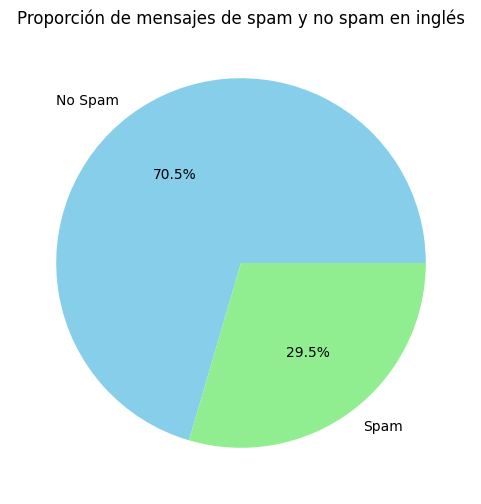

In [41]:
plt.figure(figsize=(6, 6))
english_df['type'].value_counts().rename(index={'spam': 'Spam', 'ham': 'No Spam'}).plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Proporci√≥n de mensajes de spam y no spam en ingl√©s')
plt.ylabel('')
plt.show()

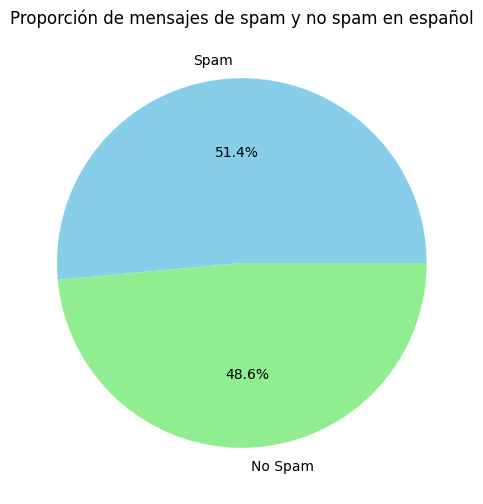

In [42]:
plt.figure(figsize=(6, 6))
spanish_df['type'].value_counts().rename(index={'spam': 'Spam', 'ham': 'No Spam'}).plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Proporci√≥n de mensajes de spam y no spam en espa√±ol')
plt.ylabel('')
plt.show()

Ser√≠a interesante ver las palabras m√°s usadas en los mensajes de spam ya que estas nos dar√°n la clave para determinar si el mensaje es spam o no.

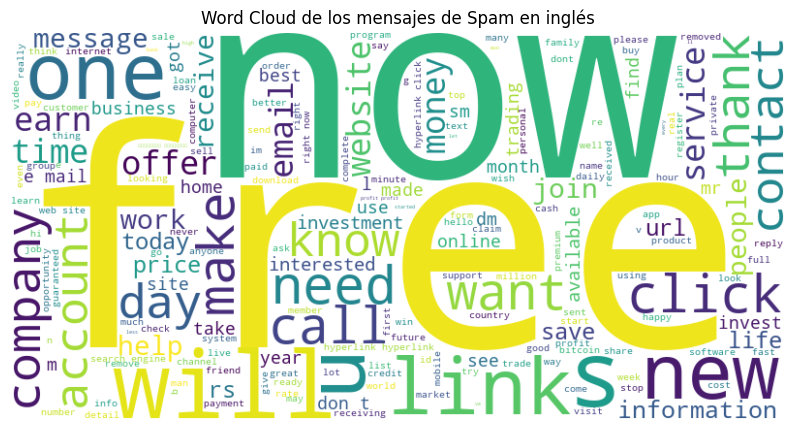

In [43]:
from wordcloud import WordCloud

# Generar el texto de spam
spam_text = ' '.join(english_df[english_df['type'] == 'spam']['text'])

# Crear la nube de palabras con una paleta de colores diferente
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(spam_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud de los mensajes de Spam en ingl√©s')
plt.axis('off')
plt.show()

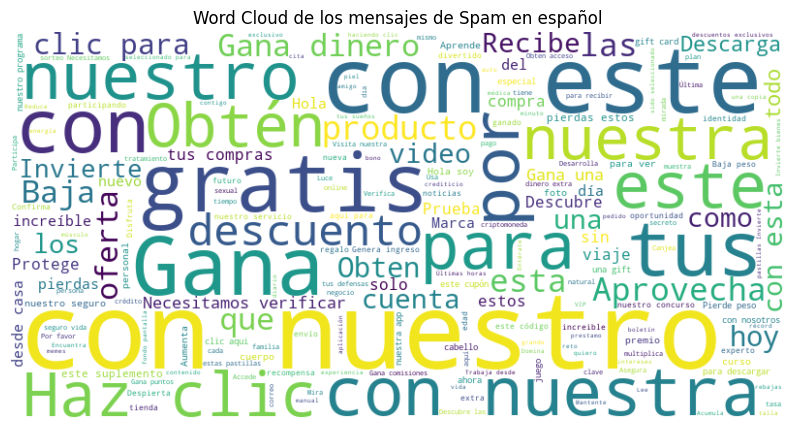

In [44]:
from wordcloud import WordCloud

# Generar el texto de spam
spam_text = ' '.join(
    # Dividir el mensaje en palabras, eliminar palabras con menos de 2 caracteres y unirlas nuevamente
    [' '.join([palabra for palabra in mensaje.split() if len(palabra) > 2])
     for mensaje in spanish_df[spanish_df['type'] == 'spam']['text']]
)

# Crear la nube de palabras con una paleta de colores diferente
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(spam_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud de los mensajes de Spam en espa√±ol')
plt.axis('off')
plt.show()

Por √∫ltimo podemos ver un histograma comparando la longitud de los mensajes de spam y de no spam.

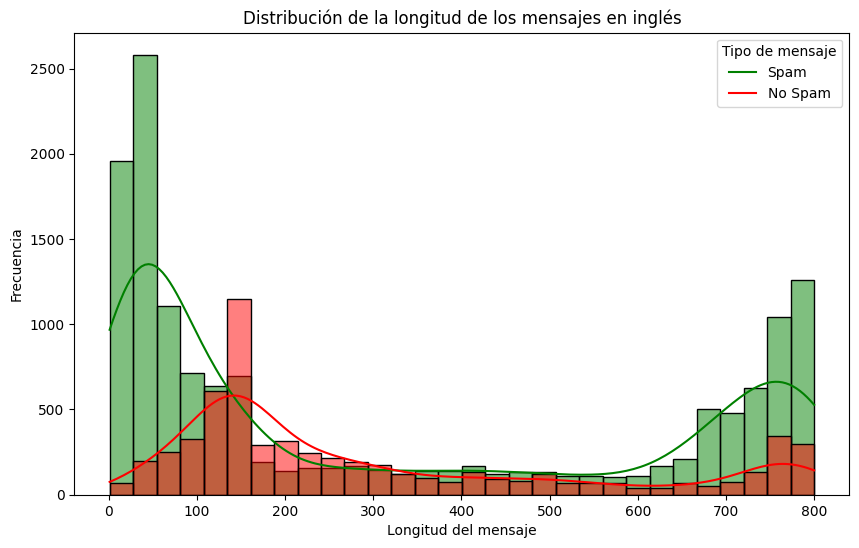

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(english_df, x=english_df['text'].apply(len), hue='type', bins=30, kde=True, palette={'spam': 'red', 'ham': 'green'})
plt.title('Distribuci√≥n de la longitud de los mensajes en ingl√©s')
plt.xlabel('Longitud del mensaje')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de mensaje', labels=['Spam', 'No Spam'])
plt.show()

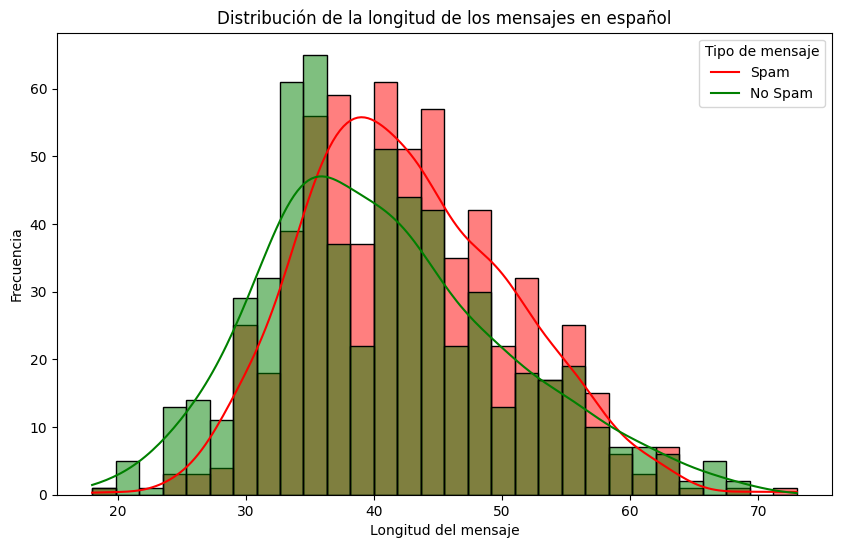

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(spanish_df, x=spanish_df['text'].apply(len), hue='type', bins=30, kde=True, palette={'spam': 'red', 'ham': 'green'})
plt.title('Distribuci√≥n de la longitud de los mensajes en espa√±ol')
plt.xlabel('Longitud del mensaje')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de mensaje', labels=['Spam', 'No Spam'])
plt.show()

## Preparaci√≥n de los datos



Cuando se trata de preparar datos de texto hay tres cosas fundamentales que debemos hacer:
- Conversi√≥n a minusculas.
- Eliminaci√≥n de signos de puntuaci√≥n y car√°cteres especiales.
- Eliminaci√≥n de palabras comunes irrelevantes (*stop words*).

#### Conversi√≥n a min√∫sculas

In [47]:
english_df['text'] = english_df['text'].str.lower()
spanish_df['text'] = spanish_df['text'].str.lower()

#### Eliminaci√≥n de signos de puntuaci√≥n y car√°teres especiales.

In [48]:
import re

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

english_df['text'] = english_df['text'].apply(remove_punctuation)
spanish_df['text'] = spanish_df['text'].apply(remove_punctuation)

#### Eliminaci√≥n de *'stop words'*

In [49]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Como sklearn no incluye un listado de stop words en espa√±ol lo haremos nosotros a mano
SPANISH_STOP_WORDS = [
    'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una',
    'su', 'al', 'es', 'lo', 'como', 'm√°s', 'pero', 'sus', 'le', 'ya', 'o', 'fue', 'este', 'ha', 's√≠', 'porque',
    'esta', 'son', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'tambi√©n', 'me', 'hasta', 'hay', 'donde', 'quien',
    'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante',
    'ellos', 'e', 'esto', 'm√≠', 'antes', 'algunos', 'qu√©', 'unos', 'yo', 'otro', 'otras', 'otra', '√©l', 'tanto',
    'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas',
    'algo', 'nosotros', 'mi', 'mis', 't√∫', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras',
    'os', 'm√≠o', 'm√≠a', 'm√≠os', 'm√≠as', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas',
    'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas',
    'estoy', 'est√°s', 'est√°', 'estamos', 'est√°is', 'est√°n', 'est√©', 'est√©s', 'estemos', 'est√©is', 'est√©n',
    'estar√©', 'estar√°s', 'estar√°', 'estaremos', 'estar√©is', 'estar√°n', 'estar√≠a', 'estar√≠as', 'estar√≠amos',
    'estar√≠ais', 'estar√≠an', 'estaba', 'estabas', 'est√°bamos', 'estabais', 'estaban', 'estuve', 'estuviste',
    'estuvo', 'estuvimos', 'estuvisteis', 'estuvieron', 'estuviera', 'estuvieras', 'estuvi√©ramos', 'estuvierais',
    'estuvieran', 'estuviese', 'estuvieses', 'estuvi√©semos', 'estuvieseis', 'estuviesen', 'estando', 'estado',
    'estada', 'estados', 'estadas', 'estad'
]

def remove_stop_words_en(text):
    return ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

def remove_stop_words_es(text):
    return ' '.join([word for word in text.split() if word not in SPANISH_STOP_WORDS])


english_df['text'] = english_df['text'].apply(remove_stop_words_en)
spanish_df['text'] = spanish_df['text'].apply(remove_stop_words_es)

### A√±adido de columna de n√∫mero de palabras sospechosas

A partir de los wordcoulds sacaremos un listado de palabras sospechosas de pertenecer a un mensaje de spam y procederemos a contar cuantas de estas palabras aparcen en nuestro texto e indicamos el n√∫mero en una columna.

In [50]:
en_suspicious_words =  [
    "free",
    "promotion",
    "discount",
    "offer",
    "investment",
    "bitcoin",
    "earn",
    "urgent",
    "limited",
    "exclusive",
    "bonus",
    "prize",
    "click here",
    "verification",
    "quick money",
    "guaranteed",
    "confidential",
    "lottery",
    "secure",
    "millionaire"
]

es_suspicious_words = [
    "gratis",
    "promoci√≥n",
    "descuento",
    "oferta",
    "inversi√≥n",
    "bitcoin",
    "ganar",
    "urgente",
    "limitado",
    "exclusivo",
    "bonificaci√≥n",
    "premio",
    "clic aqu√≠",
    "clic",
    "click aqu√≠",
    "click",
    "verificaci√≥n",
    "dinero r√°pido",
    "garantizado",
    "confidencial",
    "sorteo",
    "seguro",
    "millonario"
]

# Cuento cuantas palabras sospechosas hay en cada fila de ambos df y a√±ado la columna
english_df['suspicious_words'] = english_df['text'].apply(lambda x: sum(1 for word in en_suspicious_words if word in x))
spanish_df['suspicious_words'] = spanish_df['text'].apply(lambda x: sum(1 for word in es_suspicious_words if word in x))

### Vectorizaci√≥n de los textos

Ahora que los datos est√°n limpios vamos a convertirlos en representaciones num√©ricas para que puedan ser procesados por el modelo, usaremos para ello `TfidfVectorizer`.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizador para ingl√©s
vectorizer_en = TfidfVectorizer()
en_vec = vectorizer_en.fit_transform(english_df['text'])  # Transformamos el texto en ingl√©s

# Vectorizador para espa√±ol
vectorizer_es = TfidfVectorizer()
es_vec = vectorizer_es.fit_transform(spanish_df['text'])  # Transformamos el texto en espa√±ol

# Guardamos los vectorizadores para futuros usos en joblib
joblib.dump(vectorizer_en, './joblib/vectorizer_en.joblib')
joblib.dump(vectorizer_es, './joblib/vectorizer_es.joblib')

['./joblib/vectorizer_es.joblib']

### Separaci√≥n de datos de entrenamiento y prueba

In [52]:
from sklearn.model_selection import train_test_split

# Dividir los datos en ingl√©s en entrenamiento y prueba
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(
    en_vec, english_df['type'], test_size=0.2, random_state=42)

# Dividir los datos en espa√±ol en entrenamiento y prueba
X_train_es, X_test_es, y_train_es, y_test_es = train_test_split(
    es_vec, spanish_df['type'], test_size=0.2, random_state=42)


## Entrenamiento de los modelos y an√°lisis de rendimiento
Vamos a probar a entrenar nuestro modelo con los 3 algoritmos m√°s usados para este tipo de tarea:

- `RandomForestClassifier`
- `LogisticRegression`
- `MultinomialNB`

Despues veremos el rendimiento de cada uno y nos quedaremos con el mejor.

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import joblib

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'NaiveBayes': MultinomialNB()
}

# Diccionario para almacenar los resultados
results_en = {}
best_accuracy_en = 0  # Variable para almacenar la mejor precisi√≥n
best_model_en = None  # Variable para almacenar el mejor modelo

for model_name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train_en, y_train_en)

    # Realizar predicciones
    y_pred_en = model.predict(X_test_en)

    # Evaluar precisi√≥n y otras m√©tricas
    accuracy = accuracy_score(y_test_en, y_pred_en)
    report = classification_report(y_test_en, y_pred_en)

    # Guardar los resultados
    results_en[model_name] = {'accuracy': accuracy, 'report': report}

    print(f"Modelo en Ingl√©s - {model_name}")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("="*50)

    # Verificar si este modelo es el mejor
    if accuracy > best_accuracy_en:
        best_accuracy_en = accuracy
        best_model_en = model

# Guardar el mejor modelo en `model_en`
model_en = best_model_en
print("El mejor modelo en ingl√©s es:", model_en)

# Guardar el mejor modelo en un archivo para uso futuro
joblib.dump(model_en, './joblib/best_model_en.joblib')
print("El mejor modelo se ha guardado en 'best_model_en.joblib'")

Modelo en Ingl√©s - RandomForest
Accuracy: 0.9339066339066339
Classification Report:
               precision    recall  f1-score   support

         ham       0.92      0.99      0.96      2913
        spam       0.96      0.80      0.87      1157

    accuracy                           0.93      4070
   macro avg       0.94      0.89      0.91      4070
weighted avg       0.94      0.93      0.93      4070

Modelo en Ingl√©s - LogisticRegression
Accuracy: 0.9208845208845209
Classification Report:
               precision    recall  f1-score   support

         ham       0.92      0.98      0.95      2913
        spam       0.94      0.77      0.85      1157

    accuracy                           0.92      4070
   macro avg       0.93      0.88      0.90      4070
weighted avg       0.92      0.92      0.92      4070

Modelo en Ingl√©s - NaiveBayes
Accuracy: 0.8936117936117937
Classification Report:
               precision    recall  f1-score   support

         ham       0.88      

In [54]:

# Diccionario para almacenar los resultados
results_es = {}
best_accuracy = 0  # Variable para almacenar la mejor precisi√≥n
best_model = None  # Variable para almacenar el mejor modelo

for model_name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train_es, y_train_es)

    # Realizar predicciones
    y_pred_es = model.predict(X_test_es)

    # Evaluar precisi√≥n y otras m√©tricas
    accuracy = accuracy_score(y_test_es, y_pred_es)
    report = classification_report(y_test_es, y_pred_es)

    # Guardar los resultados
    results_es[model_name] = {'accuracy': accuracy, 'report': report}

    print(f"Modelo en Espa√±ol - {model_name}")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("="*50)

    # Verificar si este modelo es el mejor
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Guardar el mejor modelo en `model_es`
model_es = best_model
print("El mejor modelo en espa√±ol es:", model_es)

# Guardar el mejor modelo en un archivo para uso futuro
joblib.dump(model_es, './joblib/best_model_es.joblib')
print("El mejor modelo se ha guardado en 'best_model_es.joblib'")



Modelo en Espa√±ol - RandomForest
Accuracy: 0.9049586776859504
Classification Report:
               precision    recall  f1-score   support

         ham       0.94      0.87      0.90       124
        spam       0.87      0.94      0.91       118

    accuracy                           0.90       242
   macro avg       0.91      0.91      0.90       242
weighted avg       0.91      0.90      0.90       242

Modelo en Espa√±ol - LogisticRegression
Accuracy: 0.9256198347107438
Classification Report:
               precision    recall  f1-score   support

         ham       0.95      0.90      0.93       124
        spam       0.90      0.95      0.93       118

    accuracy                           0.93       242
   macro avg       0.93      0.93      0.93       242
weighted avg       0.93      0.93      0.93       242

Modelo en Espa√±ol - NaiveBayes
Accuracy: 0.9380165289256198
Classification Report:
               precision    recall  f1-score   support

         ham       0.92   

Mejores modelos:
- Para english_df `RandomForestClassifier` con **0.93** de acuraccy.
- Para spanish_df `MultinomialNB` con **0.93** de acuraccy.

In [55]:
# Recojo los modelos guardados
model_en = joblib.load('./joblib/best_model_en.joblib')
model_es = joblib.load('./joblib/best_model_es.joblib')

### Matriz de confusi√≥n

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de confusi√≥n
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam'])

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

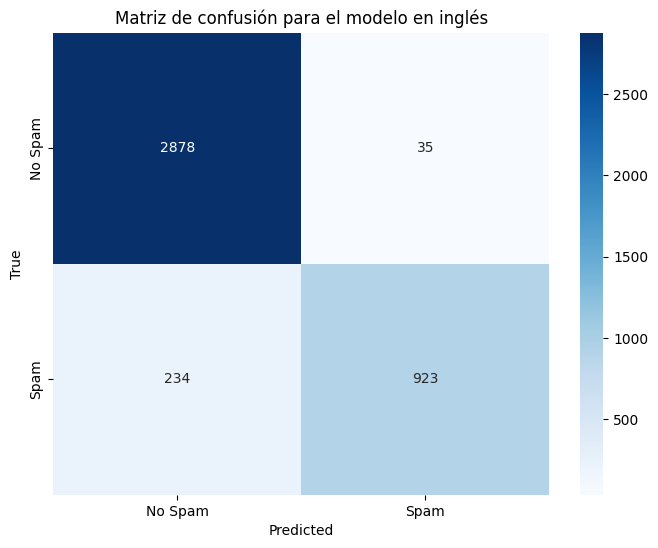

In [57]:
plot_confusion_matrix(y_test_en, model_en.predict(X_test_en), 'Matriz de confusi√≥n para el modelo en ingl√©s')

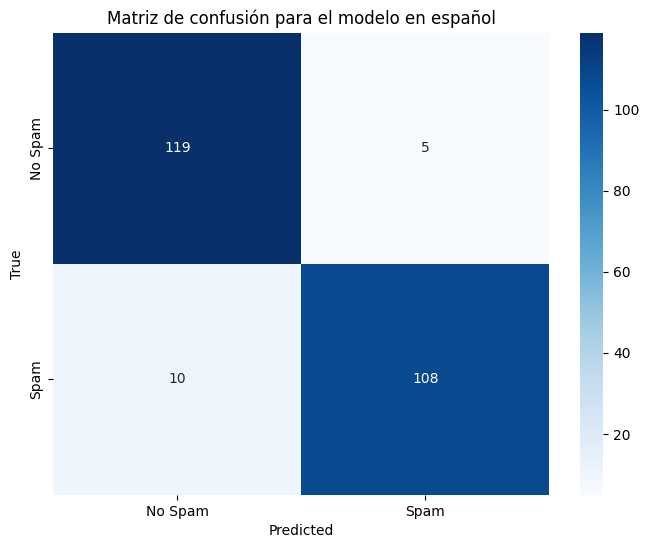

In [58]:
plot_confusion_matrix(y_test_es, model_es.predict(X_test_es), 'Matriz de confusi√≥n para el modelo en espa√±ol')

## Implementaci√≥n de detecci√≥n de idiomas.

Como hemos entrenado dos modelos diferentes, uno para espa√±ol y otro para ingl√©s, necesitamos a√±adir una capa que nos gestione que modelo usar en funci√≥n del idioma. Esto lo haremos con el m√≥dulo `langdetect`.

In [59]:
%pip install langdetect

from langdetect import detect

def detect_language(text):
    try:
        lang = detect(text)
        return lang  # 'en' para ingl√©s, 'es' para espa√±ol
    except:
        return 'unknown'

def preprocess_text(text):
    # Convertir a min√∫sculas
    text = text.lower()
    # Eliminar signos de puntuaci√≥n y caracteres especiales
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Funci√≥n de predicci√≥n final
def predict_spam(message):
    # Preprocesar el mensaje
    message = preprocess_text(message)

    # Detectar el idioma del mensaje
    language = detect_language(message)

    # Seleccionar el modelo y el vectorizador seg√∫n el idioma
    if language == 'en':
        message_vec = vectorizer_en.transform([message])  # Aplicar vectorizador en ingl√©s
        prediction = model_en.predict(message_vec)  # Usar el modelo en ingl√©s
    elif language == 'es':
        message_vec = vectorizer_es.transform([message])  # Aplicar vectorizador en espa√±ol
        prediction = model_es.predict(message_vec)  # Usar el modelo en espa√±ol
    else:
        prediction = ["Idioma desconocido"]  # Devolver un mensaje claro si no se detecta el idioma

    return prediction[0]  # Retorna la predicci√≥n (0 para ham, 1 para spam)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\d.ramirez.vaquero\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [60]:
# Ejemplos de prueba
en_spam_msg = "Congratulations! You have been selected to receive an exclusive reward! This is a one-time opportunity to claim a $1000 gift card. To redeem your reward, please click on the link below and fill in your details. Don‚Äôt miss out on this limited-time offer! Hurry, only a few rewards left. Click here to claim your prize now!"
es_spam_msg = "¬°Felicitaciones! Has sido seleccionado para recibir un premio exclusivo. Esta es una oportunidad √∫nica para ganar una tarjeta de regalo de $1000. Para reclamar tu premio, haz clic en el enlace a continuaci√≥n y completa tus datos. ¬°No dejes pasar esta oferta por tiempo limitado! Date prisa, solo quedan unos pocos premios. Haz clic aqu√≠ para obtener tu recompensa ahora."
en_ham_msg = "Hey Sarah! Are we still on for the movie tonight? Let me know what time you‚Äôll be ready, and I‚Äôll swing by to pick you up. üòä"
es_ham_msg = "Que pasa Pepe, que tal el dia? Yo por aqu√≠ ando liado cuidado a los ni√±os. ¬øTe apetece quedar para tomar algo ma√±ana? Venga ya me cuentas."

messages = [
    en_spam_msg,
    es_spam_msg,
    en_ham_msg,
    es_ham_msg
]

for msg in messages:
    print(f"Mensaje: {msg}")
    print(f"Predicci√≥n: {predict_spam(msg)}")
    print("="*50)


Mensaje: Congratulations! You have been selected to receive an exclusive reward! This is a one-time opportunity to claim a $1000 gift card. To redeem your reward, please click on the link below and fill in your details. Don‚Äôt miss out on this limited-time offer! Hurry, only a few rewards left. Click here to claim your prize now!
Predicci√≥n: spam
Mensaje: ¬°Felicitaciones! Has sido seleccionado para recibir un premio exclusivo. Esta es una oportunidad √∫nica para ganar una tarjeta de regalo de $1000. Para reclamar tu premio, haz clic en el enlace a continuaci√≥n y completa tus datos. ¬°No dejes pasar esta oferta por tiempo limitado! Date prisa, solo quedan unos pocos premios. Haz clic aqu√≠ para obtener tu recompensa ahora.
Predicci√≥n: spam
Mensaje: Hey Sarah! Are we still on for the movie tonight? Let me know what time you‚Äôll be ready, and I‚Äôll swing by to pick you up. üòä
Predicci√≥n: ham
Mensaje: Que pasa Pepe, que tal el dia? Yo por aqu√≠ ando liado cuidado a los ni√±os. ¬ø